In [1]:
#import necessary packages 
import numpy as np
import codecs, json
import matplotlib.pyplot as plt
import math
from mpl_toolkits import mplot3d
from scipy.stats.stats import pearsonr   



$$ \textbf{2. Understanding the Data Set}$$

In [2]:
def load_json_files(file_path):

    #  load data from json file
    with codecs.open(file_path, 'r', encoding='utf-8') as handle:
        json_data = json.loads(handle.read())

    # if a string, then returns list of strings
    if not isinstance(json_data[0], str):
        # otherwise, it's assumed to be numeric and returns numpy array
        json_data = np.array(json_data)

    return json_data

In [3]:
#upload data 
swiss_roll_points=load_json_files("/Users/dashka/Downloads/CPSC453 PS1 2/Data/swiss_roll_points.json")
swiss_roll_labels=load_json_files("/Users/dashka/Downloads/CPSC453 PS1 2/Data/swiss_roll_labels.json")
ipsc_channel_names=load_json_files("/Users/dashka/Downloads/CPSC453 PS1/Data/ipsc_channel_names.json")
ipsc_data= load_json_files("/Users/dashka/Downloads/CPSC453 PS1/Data/ipsc_data.json")


In [4]:
#mean center the data by subtracting the mean of each column from the entries 
def centering(data):
    mean_center=np.empty(data.shape)
    for i in range(0,len(data[0])):
        mean_center[:,i]=(data[:,i]-np.mean(data[:,i], axis=0))
    return mean_center
mean_center_labels=swiss_roll_labels-np.mean(swiss_roll_labels, axis=0)
mean_center_swiss_points=centering(swiss_roll_points)

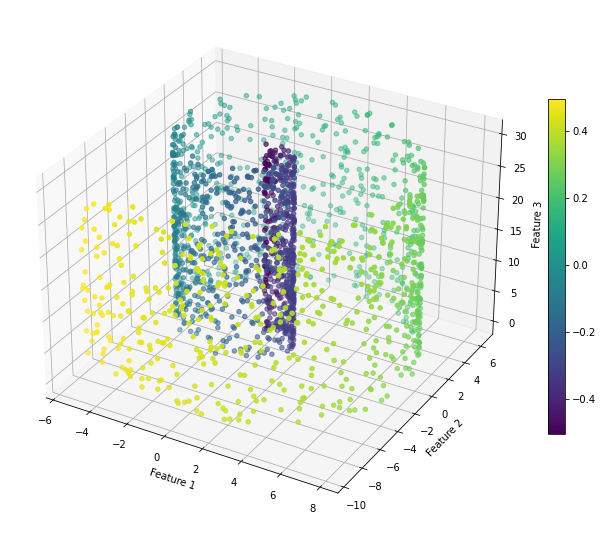

In [5]:
#plot the data
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
zdata = swiss_roll_points[:,2]
xdata = swiss_roll_points[:,0]
ydata = swiss_roll_points[:,1]
pm=ax.scatter3D(xdata, ydata, zdata,c=mean_center_labels
               );
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
fig.colorbar(pm, ax=ax, fraction=0.03, pad=0.04)

$$ \textbf{2.1 Visualizing data with PCA}$$

In [6]:
#take the singular value decomposition of the mean centered data and 
#use US to find the principal components and S to find the singular values 
def PCA(data):
    u,s,v = np.linalg.svd(data)
    S = np.zeros((len(u), len(v)))
    S[:len(v), :len(v)] = np.diag(s)
    print("The principle components are the columns of: \n", np.dot(u,S))
    print("The singular values are: \n" , s)
    return  u,S,s
u,S,s= PCA(mean_center_swiss_points)


The principle components are the columns of: 
 [[  4.01541113  -3.0419295   -6.45378697]
 [-10.40102067   0.58000427  -7.18121979]
 [ 15.13618491  -3.10452446  -6.18886907]
 ...
 [-10.05496844   0.91436147   0.58339848]
 [  1.3144476    7.22479456   0.34384618]
 [ 13.43855012   1.39156608  -0.41830526]]
The singular values are: 
 [388.60459679 194.04638291 165.55193519]


Text(0.5, 1.0, 'Singular Values Plot')

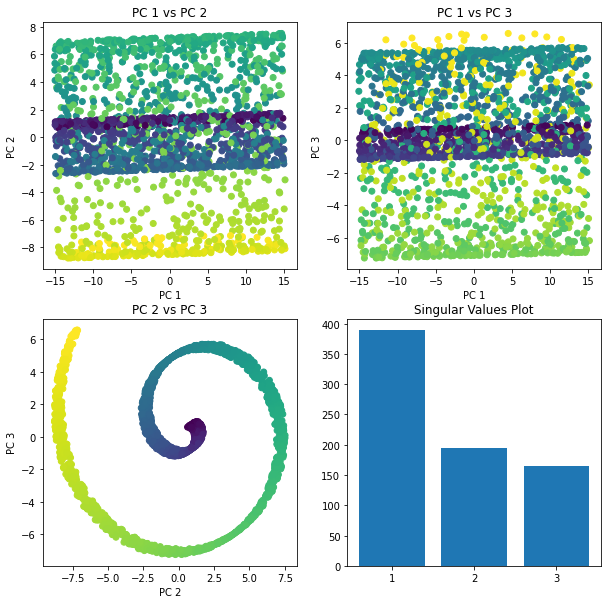

In [7]:
#plot PC1 vs. PC2, PC2 vs. PC3 , PC1 vs PC3 and scree plot

fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0, 0].scatter(np.dot(u,S)[:,0], np.dot(u,S)[:,1], c = swiss_roll_labels)
ax[0, 0].set_xlabel("PC 1")
ax[0, 0].set_ylabel("PC 2")
ax[0, 0].set_title("PC 1 vs PC 2")

ax[1, 0].scatter(np.dot(u,S)[:,1], np.dot(u,S)[:,2], c = swiss_roll_labels)
ax[1, 0].set_xlabel("PC 2")
ax[1, 0].set_ylabel("PC 3")
ax[1, 0].set_title("PC 2 vs PC 3")

ax[0, 1].scatter(np.dot(u,S)[:,0], np.dot(u,S)[:,2], c = swiss_roll_labels)
ax[0, 1].set_xlabel("PC 1")
ax[0, 1].set_ylabel("PC 3")
ax[0, 1].set_title("PC 1 vs PC 3")
    
x=["1","2", "3"]    
ax[1, 1].bar(x,s)
ax[1, 1].set_title("Singular Values Plot")




$$ \textbf{4.1 Visualizing data with Diffusion Maps}$$

In [8]:
#plotting function for later use 

def plotting(matrix, labels, eigenvalues):
    fig, ax = plt.subplots(2, 2, figsize=(12,12))

    ax[0, 0].scatter(matrix[:,0], matrix[:,1], c = labels)
    ax[0, 0].set_xlabel("Coordinate 1")
    ax[0, 0].set_ylabel("Coordinate 2")
    ax[0, 0].set_title("Coordinate 1 vs Coordinate 2")

    ax[1, 0].scatter(matrix[:,1], matrix[:,2], c = labels)
    ax[1, 0].set_xlabel("Coordinate 2")
    ax[1, 0].set_ylabel("Coordinate 3")
    ax[1, 0].set_title("Coordinate 2 vs Coordinate 3")

    ax[0, 1].scatter(matrix[:,0], matrix[:,2], c = labels)
    ax[0, 1].set_xlabel("Coordinate 1")
    ax[0, 1].set_ylabel("Coordinate 3")
    ax[0, 1].set_title("Coordinate 1 vs Coordinate 3")
        
    ax[1, 1].plot(eigenvalues)
    ax[1, 1].set_title("Eigenvalues")

In [9]:
#compute_distances takes in a matrix, computes a matrix of Euclidean distances, 
#and impliments either a static or adaptive kernel 
def compute_distances(X):
    
    #matrix of Euclidean distances
    distance_matrix=np.empty((len(X), len(X)))
    for i in range(0,len(X)):
        for j in range(0, len(X)):
            distance_matrix[i][j] = np.sqrt((X[i,:]-X[j,:]) @ (X[i,:]-X[j,:])) 
    
               
    return distance_matrix



In [10]:
def compute_affinity_matrix(D, kerneltype, sigma=None, k=None):
    #computes using static type kernel with fixed sigma 
    W=np.empty((len(D), len(D)))
    if (kerneltype=="static"):
        
        for i in range(0,len(D)):
            for j in range(0, len(D)):
                W[i][j]=np.exp(((-(D[i,j])**2))/sigma**2)
    
    #uses helper functions to implement Gaussian k-nearest neighbor kernel 
    if (kerneltype=="adaptive"):
        sorted_distance_matrix=np.empty((len(D), len(D)))
        for i in range(0,len(D)):
            sorted_distance_matrix[i,:]=np.sort(D[i,:][::-1])
        for i in range(0,len(D)):
            for j in range(0, len(D)):
                denominator=(-1*(D[i,j])**2)
                W[i][j]=0.5*(np.exp(denominator/(sorted_distance_matrix[i,k])\
                **2)+np.exp(denominator/(sorted_distance_matrix[j,k])**2))
    # return the affinity matrix
    return W

In [11]:

def diff_map_info(W):
   #takes in kernel matrix
    D_half=np.diag((np.sum(W, axis=1)**(-0.5)))
    
    #construct symmetric matrix 
    M= D_half @ W @ D_half 
    
    #compute eigenvector and values
    diff_eig, diff_vec= np.linalg.eigh(M)
    
    #sort eigenvalues and eigenvectors
    inds = (np.argsort(diff_eig))
    inds=inds[::-1]
    diff_eig = diff_eig[inds][0:W.shape[0]]
    diff_vec = diff_vec[:, inds]
    diff_vec_norm=np.empty(diff_vec.shape)
    eigvectors = D_half @ diff_vec
    
    #normalize eigenvectors 
    eigvectors = (eigvectors) / np.linalg.norm(eigvectors, axis = 0)
    diff_vec = eigvectors[:, 0:W.shape[0]]
    
    return diff_vec, diff_eig



In [21]:
def get_diff_map(diff_vec, diff_eig, t):
    #remove first eigenvector and eigenvalue
    diff_eig=np.delete(diff_eig,0)
    
    diff_vec=diff_vec[:, 1:len(diff_vec[0])]
    
    #construct diffusion map
    diff_map=np.empty(diff_vec.shape)
    
    for i in range(0, len(diff_eig)):
        diff_map[:,i]=diff_eig[i]**t*diff_vec[:,i]

    return diff_map



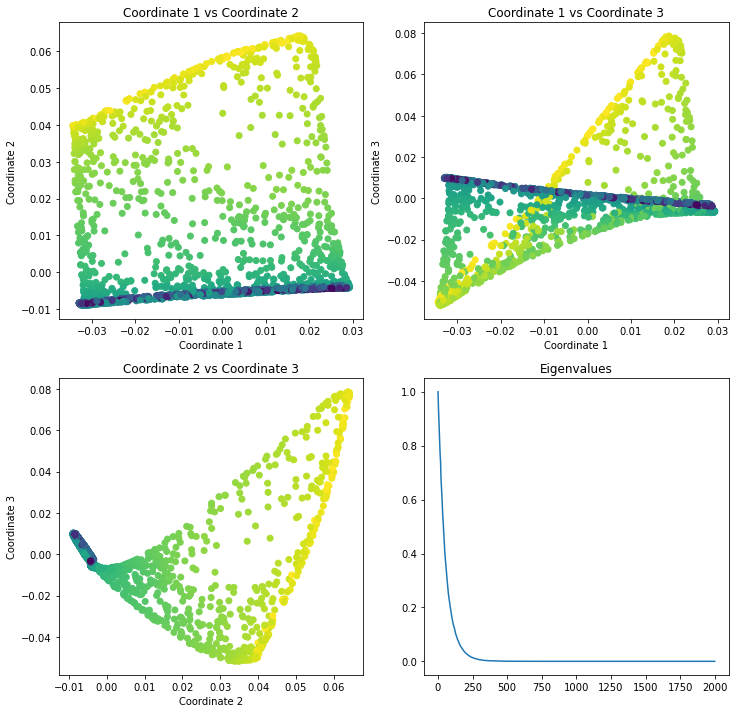

In [22]:
#find and plot diffusion matrix for t=1 and sigma=3
distances=compute_distances(mean_center_swiss_points)
aff_matrix=compute_affinity_matrix(distances, 'static',sigma=3)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,1)
plotting(diff_map, mean_center_labels , eigs)


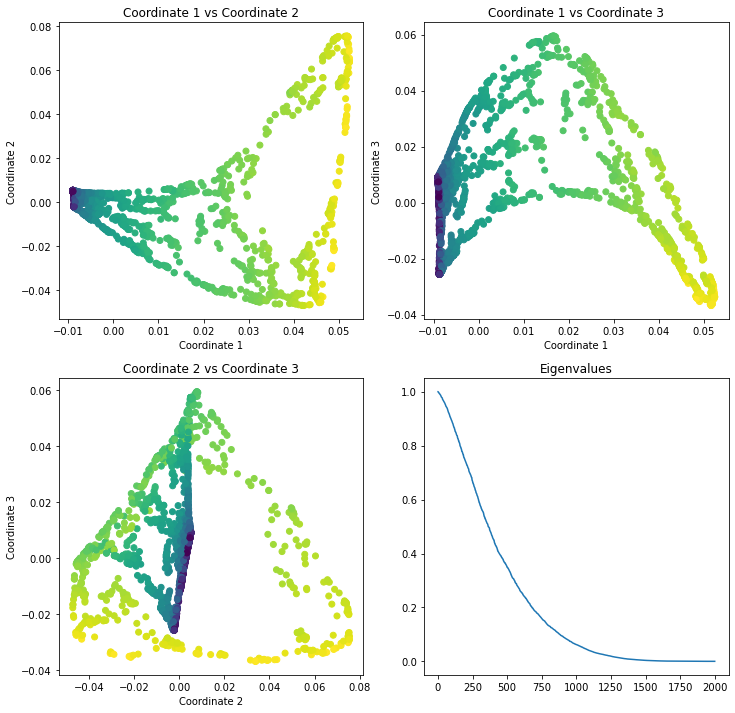

In [23]:
#find and plot diffusion matrix for t=1 and sigma=1
distances=compute_distances(mean_center_swiss_points)
aff_matrix=compute_affinity_matrix(distances, 'static',sigma=1)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,1)
plotting(diff_map, mean_center_labels , eigs)

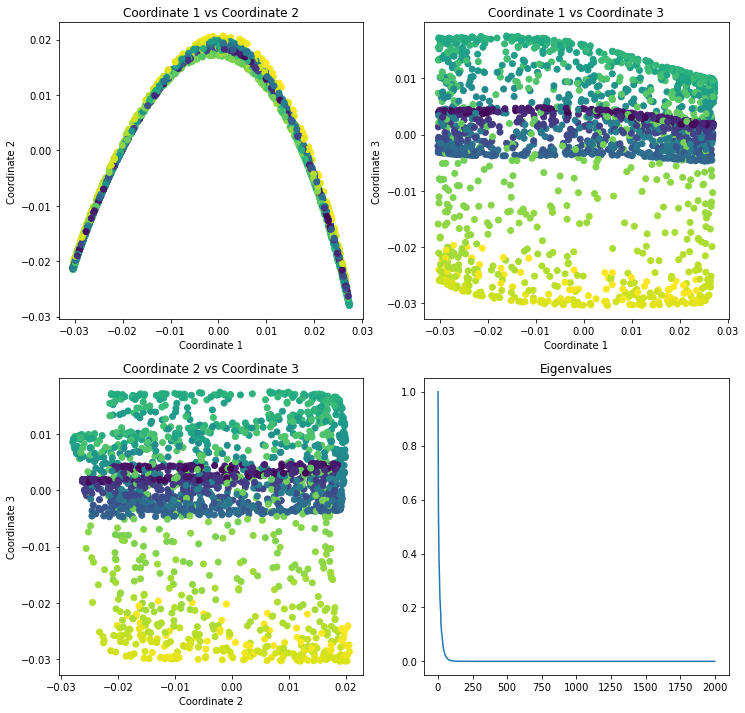

In [24]:
#find and plot diffusion matrix for t=1 and sigma=6
distances=compute_distances(mean_center_swiss_points)
aff_matrix=compute_affinity_matrix(distances, 'static',sigma=6)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,1)
plotting(diff_map, mean_center_labels , eigs)

$$ \textbf{5. Understandin the first eigenvector of the Markov Matrix}$$

In [25]:
#compute the Markov matrix and take its left eigenvector using earlier written functions 
dist_matrix=compute_distances(mean_center_swiss_points)
aff_matrix=compute_affinity_matrix(dist_matrix, "static", sigma=1)
D_half=np.diag((np.sum(aff_matrix, axis=1)**(0.5)))
D_one=np.diag((np.sum(aff_matrix, axis=1)**(-1)))
M=D_one@aff_matrix 
eigs, vecs= np.linalg.eigh(M)
indices = np.argsort(eigs)
v_1=vecs[:,indices[0]]
phi=v_1@D_half 
print(phi)


[-4.82424921e-19 -6.84280544e-17 -6.19231857e-17 ...  4.64311354e-03
 -7.97880753e-17  2.48498027e-16]


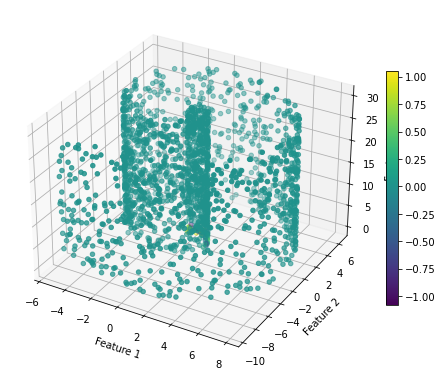

In [26]:
#plot, coloring by largest eigenvector
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')
zdata = swiss_roll_points[:,2]
xdata = swiss_roll_points[:,0]
ydata = swiss_roll_points[:,1]
pm=ax.scatter3D(xdata, ydata, zdata,c=phi);
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
fig.colorbar(pm, ax=ax, fraction=0.03, pad=0.04)



$$ \textbf{5.1 Using an adaptive Gaussian Kernel}$$

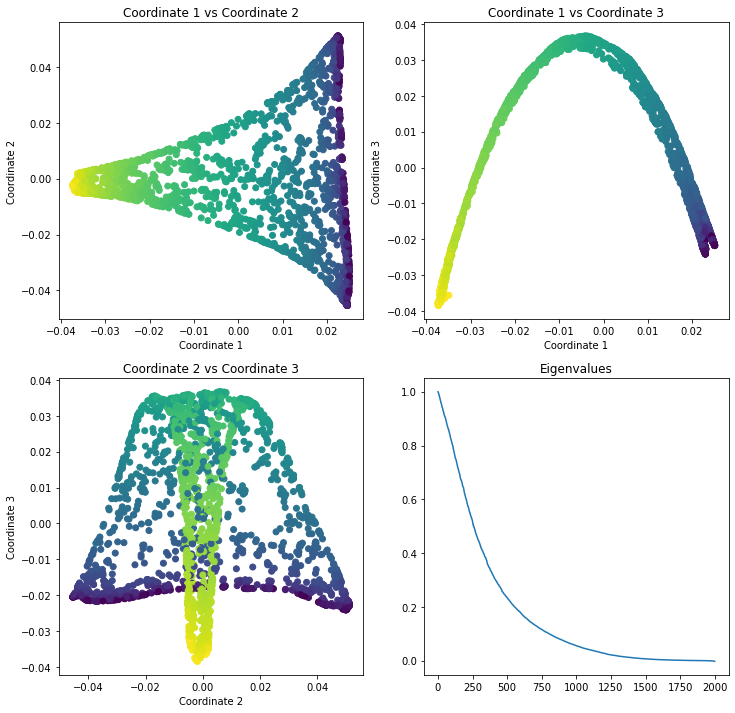

In [27]:
#plot using an adaptive kernel with k=5
distances=compute_distances(mean_center_swiss_points)
aff_matrix=compute_affinity_matrix(distances, 'adaptive',k=5)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,1)
plotting(diff_map, mean_center_labels , eigs)

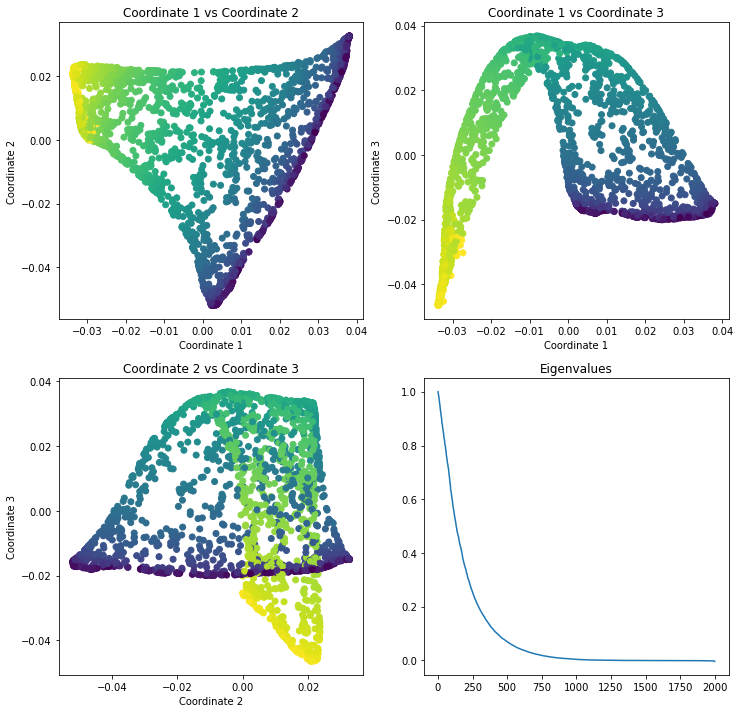

In [28]:
#plot using an adaptive kernel with k=10

distances=compute_distances(mean_center_swiss_points)
aff_matrix=compute_affinity_matrix(distances, 'adaptive',k=10)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,1)
plotting(diff_map, mean_center_labels , eigs)

$$ \textbf{5.2 Changing the diffusion parameter t}$$

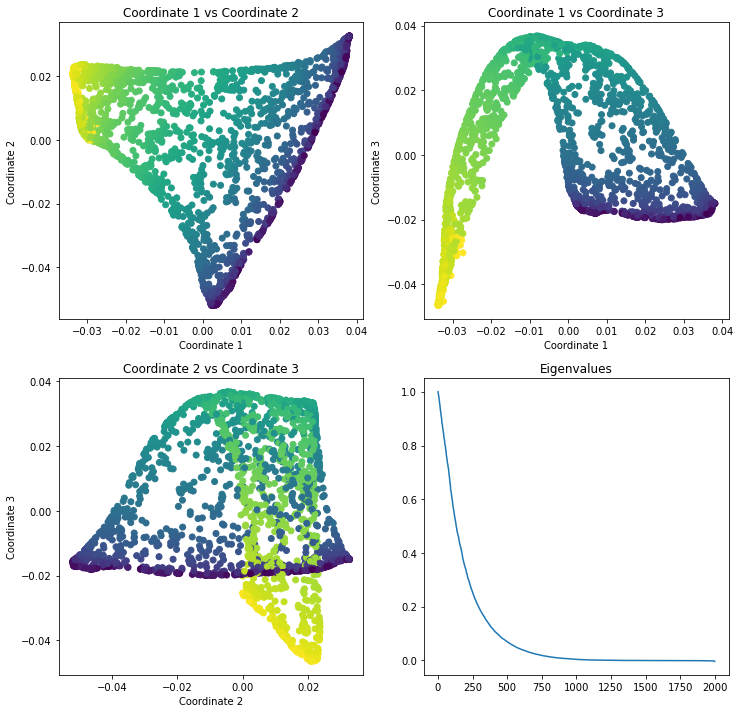

In [29]:
#plot using an adaptive kernel with k=10

distances=compute_distances(mean_center_swiss_points)
aff_matrix=compute_affinity_matrix(distances, 'adaptive',k=10)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,1)
plotting(diff_map, mean_center_labels , eigs)

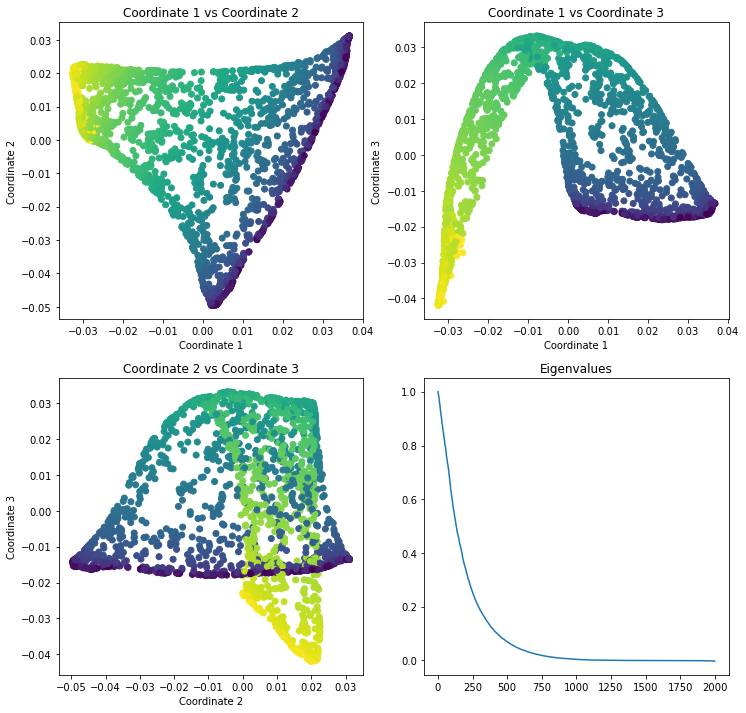

In [30]:
#plot using an adaptive kernel with t=10
distances=compute_distances(mean_center_swiss_points)
aff_matrix=compute_affinity_matrix(distances, 'adaptive',k=10)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,10)
plotting(diff_map, mean_center_labels , eigs)

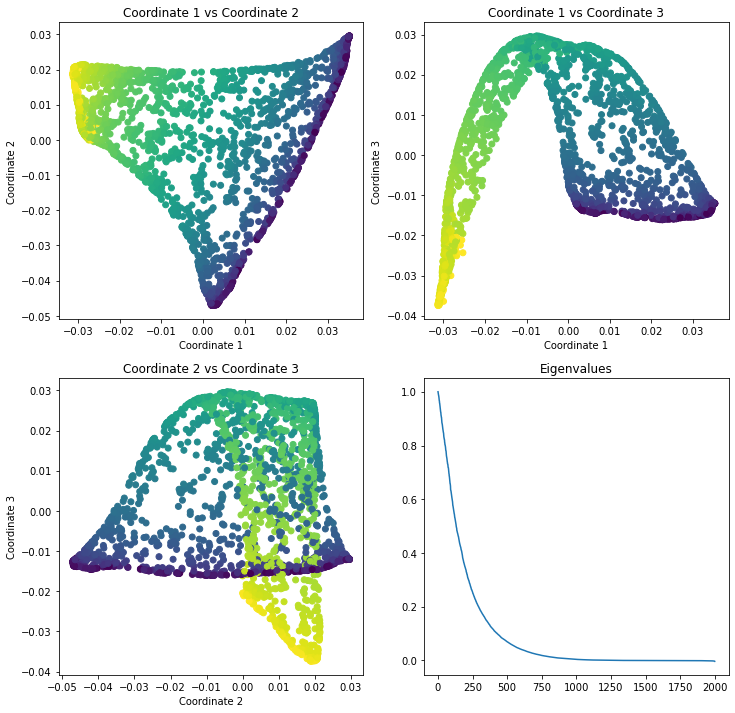

In [31]:
#plot using an adaptive kernel with t=20
distances=compute_distances(mean_center_swiss_points)
aff_matrix=compute_affinity_matrix(distances, 'adaptive',k=10)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,20)
plotting(diff_map, mean_center_labels , eigs)

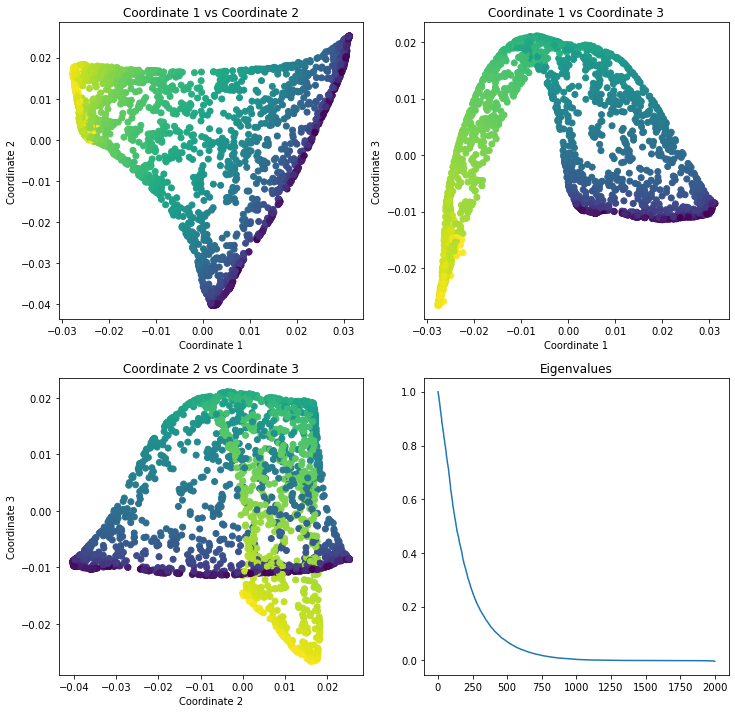

In [32]:
#plot using an adaptive kernel with t=50
distances=compute_distances(mean_center_swiss_points)
aff_matrix=compute_affinity_matrix(distances, 'adaptive',k=10)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,50)
plotting(diff_map, mean_center_labels , eigs)

$$ \textbf{6.1 Visualizing data with PCA }$$

In [33]:
centered_data=centering(ipsc_data)
components, singular_val_matrix,singvals =PCA(centered_data)
top_5_components=components[:,0:5]
top_5_singvals=singvals[0:5]


The principle components are the columns of: 
 [[-6.88462027e+00 -7.48552660e+00 -1.74263063e+00 ...  5.74242799e-01
   3.22092393e-02  5.67450160e-02]
 [-1.81102390e+00  7.22117890e+00  7.85805337e-01 ...  4.92778736e-01
  -4.55320732e-01 -4.25609276e-01]
 [ 2.64685843e+00  6.44377634e+00  2.07468954e-01 ... -2.58433933e-01
  -6.52076614e-02 -1.04492349e-01]
 ...
 [-1.00590669e+01 -5.60557111e+00 -1.14428027e+00 ...  2.35460591e-01
  -2.36924928e-01  4.11230097e-01]
 [ 1.21029247e+00 -5.23457360e-01 -4.16386154e+00 ...  6.04426497e-01
  -6.80342289e-01  3.18757708e-01]
 [ 1.35556742e-01  2.47603086e+00 -5.93233695e+00 ...  3.37649283e-01
   1.23503240e-03 -7.59491083e-02]]
The singular values are: 
 [187.95852218 162.50346932 111.87200507 101.87682359  85.92705467
  74.80877622  70.04470068  65.45496377  60.96943886  60.18312875
  58.78540851  54.58352307  51.82273753  50.60310829  49.15702757
  46.52660644  45.8710361   44.71614819  43.86064479  42.32729047
  41.41062519  38.63179425

Text(0.5, 1.0, 'Singular Values Plot')

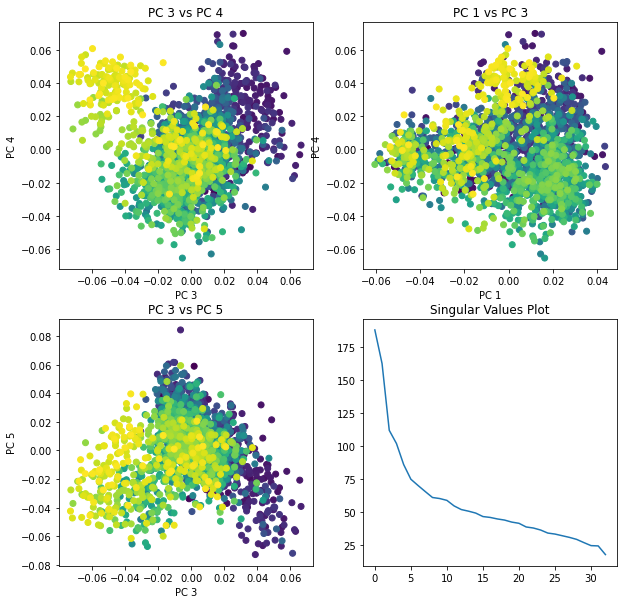

In [34]:
#plot PC1 vs. PC2, PC2 vs. PC3 , PC1 vs PC3 and scree plot

fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0, 0].scatter(top_5_components[:,2], top_5_components[:,3], c=np.arange(len(centered_data)))
ax[0, 0].set_xlabel("PC 3")
ax[0, 0].set_ylabel("PC 4")
ax[0, 0].set_title("PC 3 vs PC 4")

ax[1, 0].scatter(top_5_components[:,2], top_5_components[:,4] , c=np.arange(len(centered_data)))
ax[1, 0].set_xlabel("PC 3")
ax[1, 0].set_ylabel("PC 5")
ax[1, 0].set_title("PC 3 vs PC 5")

ax[0, 1].scatter(top_5_components[:,0], top_5_components[:,3], c=np.arange(len(centered_data )))
ax[0, 1].set_xlabel("PC 1")
ax[0, 1].set_ylabel("PC 4")
ax[0, 1].set_title("PC 1 vs PC 3")
    
 
ax[1, 1].plot(singvals)
ax[1, 1].set_title("Singular Values Plot")



$$ \textbf{6.1 Visualizing data with Diffusion Maps }$$

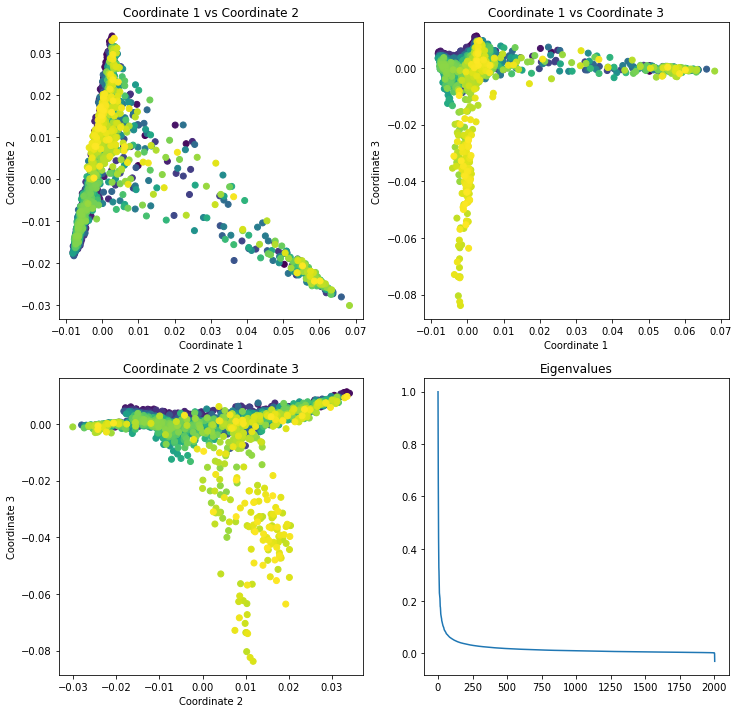

In [35]:
distances=compute_distances(centered_data)
aff_matrix=compute_affinity_matrix(distances, 'adaptive',k=2)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,1)

plotting(diff_map, np.arange(len(centered_data)),eigs )

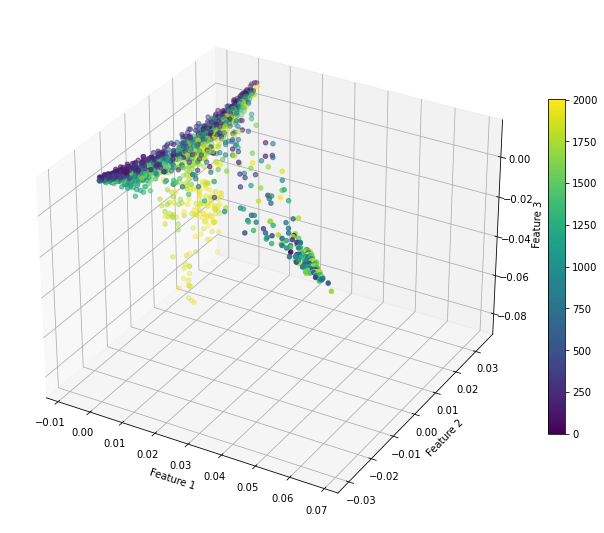

In [36]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
zdata = diff_map[:,2]
xdata = diff_map[:,0]
ydata = diff_map[:,1]
pm=ax.scatter3D(xdata, ydata, zdata,c=np.arange(len(centered_data)) );
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
fig.colorbar(pm, ax=ax, fraction=0.03, pad=0.04)


In [37]:
print("The channels most correlated with the first diffusion components are: ")
corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,0])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])
    
print("The channels most correlated with the second diffusion components are: ")

corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,1])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])

print("The channels most correlated with the third diffusion components are: ")
    
corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,2])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])

The channels most correlated with the first diffusion components are: 
h3k9ac
prb
pplk1
pstat3-727
pampk
The channels most correlated with the second diffusion components are: 
bcatenin
cd140a
ikba
mefsk4
oct4
The channels most correlated with the third diffusion components are: 
lin28
ssea1
epcam
cd44
gfp


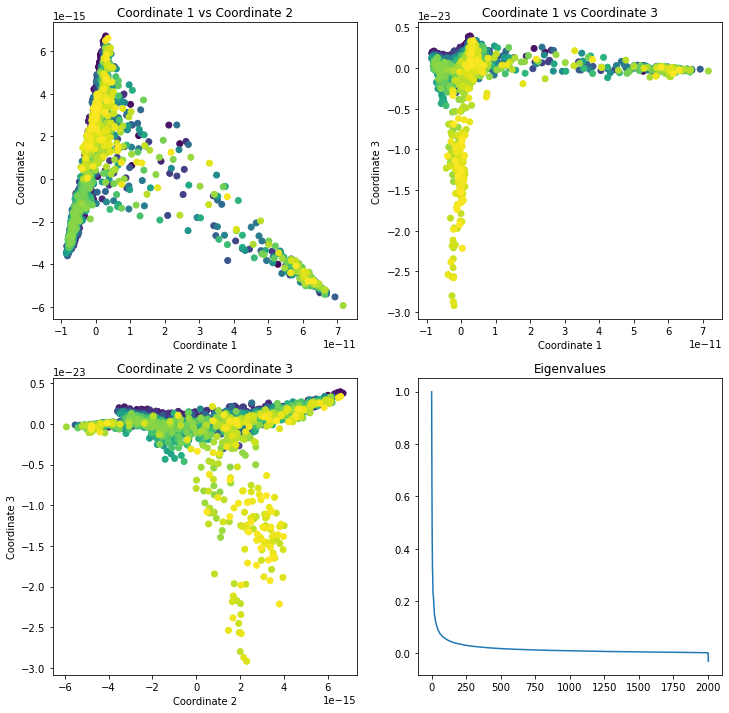

In [38]:
distances=compute_distances(centered_data)
aff_matrix=compute_affinity_matrix(distances, 'adaptive',k=2)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,70)

plotting(diff_map, np.arange(len(centered_data)),eigs )

In [39]:
print("The channels most correlated with the first diffusion components are: ")
corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,0])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])
    
print("The channels most correlated with the second diffusion components are: ")

corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,1])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])

print("The channels most correlated with the third diffusion components are: ")
    
corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,2])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])

The channels most correlated with the first diffusion components are: 
h3k9ac
prb
pplk1
pstat3-727
pampk
The channels most correlated with the second diffusion components are: 
bcatenin
cd140a
ikba
mefsk4
oct4
The channels most correlated with the third diffusion components are: 
lin28
ssea1
epcam
cd44
gfp


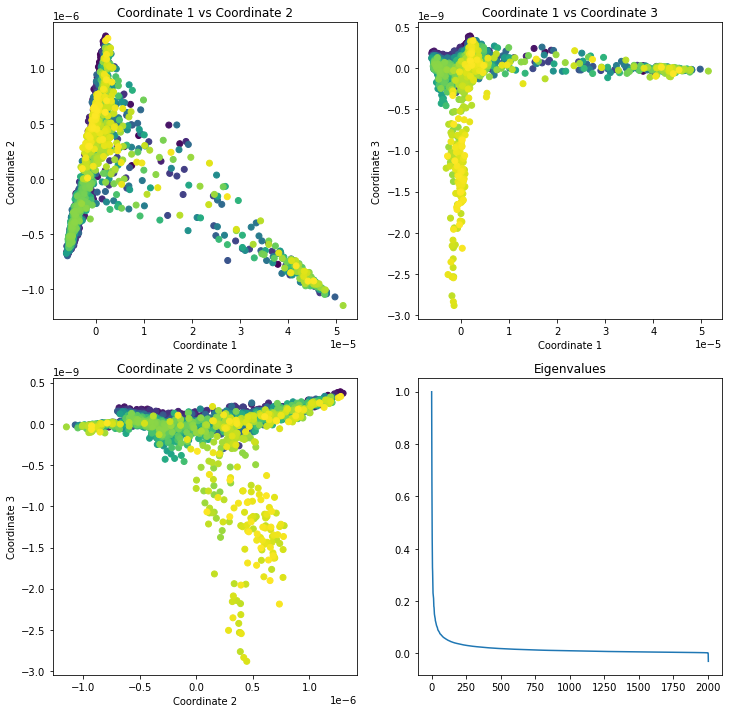

In [40]:
distances=compute_distances(centered_data)
aff_matrix=compute_affinity_matrix(distances, 'adaptive',k=2)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,25)

plotting(diff_map, np.arange(len(centered_data)),eigs )

In [41]:
print("The channels most correlated with the first diffusion components are: ")
corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,0])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])
    
print("The channels most correlated with the second diffusion components are: ")

corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,1])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])

print("The channels most correlated with the third diffusion components are: ")
    
corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,2])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])

The channels most correlated with the first diffusion components are: 
h3k9ac
prb
pplk1
pstat3-727
pampk
The channels most correlated with the second diffusion components are: 
bcatenin
cd140a
ikba
mefsk4
oct4
The channels most correlated with the third diffusion components are: 
lin28
ssea1
epcam
cd44
gfp


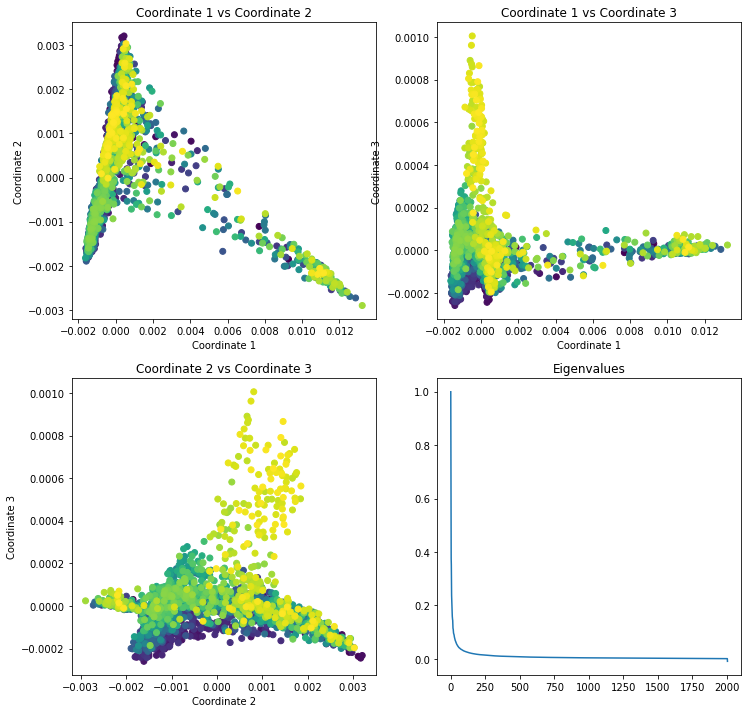

In [42]:
distances=compute_distances(centered_data)
aff_matrix=compute_affinity_matrix(distances, 'adaptive',k=10)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,5)

plotting(diff_map, np.arange(len(centered_data)),eigs )



In [43]:
print("The channels most correlated with the first diffusion components are: ")
corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,0])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])
    
print("The channels most correlated with the second diffusion components are: ")

corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,1])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])

print("The channels most correlated with the third diffusion components are: ")
    
corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,2])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])

The channels most correlated with the first diffusion components are: 
h3k9ac
prb
pplk1
pstat3-727
pampk
The channels most correlated with the second diffusion components are: 
bcatenin
cd140a
ikba
mefsk4
oct4
The channels most correlated with the third diffusion components are: 
lin28
epcam
ssea1
sox2
thy1


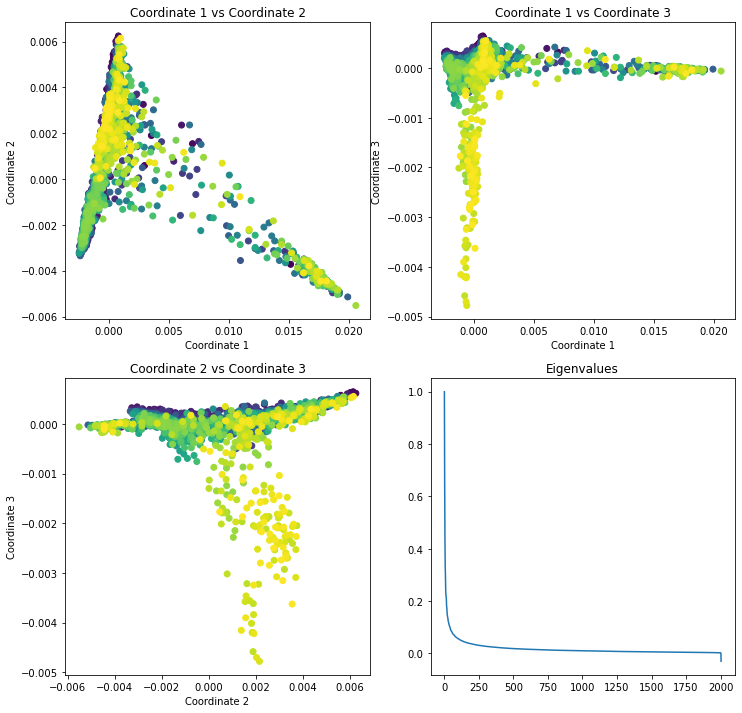

In [44]:
distances=compute_distances(centered_data)
aff_matrix=compute_affinity_matrix(distances, 'adaptive',k=2)
vecs,eigs=diff_map_info(aff_matrix)
diff_map=get_diff_map(vecs,eigs,5)

plotting(diff_map, np.arange(len(centered_data)),eigs )

In [45]:
print("The channels most correlated with the first diffusion components are: ")
corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,0])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])
    
print("The channels most correlated with the second diffusion components are: ")

corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,1])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])

print("The channels most correlated with the third diffusion components are: ")
    
corr_array1=[]
for i in range(0,len(centered_data[0])):
        corr_array1.append(pearsonr(centered_data[:,i], diff_map[:,2])[0])
sorted_corr1=np.abs((corr_array1)).argsort()[-5:][::-1]

for j in sorted_corr1:
    print(ipsc_channel_names[j])

The channels most correlated with the first diffusion components are: 
h3k9ac
prb
pplk1
pstat3-727
pampk
The channels most correlated with the second diffusion components are: 
bcatenin
cd140a
ikba
mefsk4
oct4
The channels most correlated with the third diffusion components are: 
lin28
ssea1
epcam
cd44
gfp
